In [1]:
import pandas as pd
import numpy as np
import os

import constants
import utils
import utils_ml

### **Objetivo**

**Determinar cuando una persona quedará sin bolsa de creditos**
1. **Proyectar** la **bolsa de creditos** de los beneficiarios de jovenes a la U/E.
2. **Clasificar** al estudiante con o sin bolsa de creditos.
 

### **Datos**

Tenemos datos panel (pseudo-artificiales) de los beneficiarios. Al contar unicamente con una observación de la bolsa de creditos acumulada por individuo (dependiendo de la convocatoria a la que pertenece), se realizaron estimaciones de la bolsa para los semestres anteriores al momento observado. Esto se hizo  a partir de un **Propensity Score Matching**.

---

### **Lectura datos**

In [2]:
data = pd.read_pickle("../Panel/panel_estudiantes.pkl").drop(columns="Unnamed: 22")

**Limpieza**

In [3]:
# Quitar observaciones con estado no aplica. El estado no aplica identifica semestres que el individuo todavía no ha cursado. 
data = data.query("estado_next!='No aplica'")

**Manipulacion datos**

In [4]:
#Agregar la columna semestre
data = utils.calcular_semestre(data)
#separar los datos panel segun el nivel de formacion
panel_data = {
    "universitario": data.query("NIVEL_FORMACION=='UNIVERSITARIO'"),
    "tecnico": data.query("NIVEL_FORMACION=='FORMACION TECNICA PROFESIONAL'"),
    "tecnologico": data.query("NIVEL_FORMACION=='TECNOLOGICO'")
}
print(f"*Columnas en el Panel:*\n {data.columns}\n")
print(f"*Tipos de estados:*\n{data.estado_next.unique()}")

*Columnas en el Panel:*
 Index(['DOCUMENTO', 'NIVEL_SISBEN_4', 'SEXO', 'GRUPO_ETNICO', 'HIJOS',
       'SABER11_PUNTAJE_GLOBAL', 'NIVEL_FORMACION', 'CINE_CAMPO_AMPLIO',
       'MODALIDAD', 'estado', 'periodo_key', 'pct_perd_acum', 'pct_aprob_acum',
       'N_Aplazado', 'N_Matriculado', 'N_Abandono', 'N_Sin_bolsa_de_creditos',
       'N_Pérdida_del_beneficio', 'N_Matriculas_adicionales', 'N_Graduado',
       't', 'estado_next', 'semestre'],
      dtype='object')

*Tipos de estados:*
['Matriculado' nan 'Abandono' 'Aplazado' 'Pérdida del Beneficio'
 'Graduado' 'Sin bolsa de creditos']


**Datos complementarios**:
- Estos datos salieron de otro ejercicio 

In [5]:
universitario = pd.read_pickle("../data/universitario.pkl")[constants.COLS_COMPLEMENTO]
tecnologico = pd.read_pickle("../data/tecnologico.pkl")[constants.COLS_COMPLEMENTO]
tecnico = pd.read_pickle("../data/tecnico.pkl")[constants.COLS_COMPLEMENTO]

**Merge**: Los datos complementarios traen columnas como *CREDITOS_PERIODO, PERIODOS_BD_SNIES*

In [6]:
panel_merged_dict = utils.merge_data(data, panel_data, universitario, tecnologico, tecnico)

universitario_merged = panel_merged_dict['universitario']
tecnico_merged = panel_merged_dict['tecnico']
tecnologico_merged = panel_merged_dict['tecnologico']

panel_merged_data = pd.concat([universitario_merged,tecnico_merged,tecnologico_merged])

#Unir categorias que tienen pocas observaciones
panel_merged_data = utils_ml.combine_categories(
    panel_merged_data,
    column="MODALIDAD",
    categories_to_combine=["PRESENCIAL-VIRTUAL", "PRESENCIAL-DUAL"],
    new_category="OTRA"
)

panel_merged_data = utils_ml.combine_categories(
    panel_merged_data,
    column="JORNADA",
    categories_to_combine=["UNICA", "SIN INFORMACION", np.nan],
    new_category="OTRA"
)

panel_merged_data = utils_ml.combine_categories(
    panel_merged_data,
    column = "HIJOS",
    categories_to_combine = ["DOS HIJOS","MAS DE DOS HIJOS", "UN HIJO"],
    new_category = "CON HIJOS"
)

panel_merged_data = utils_ml.combine_categories(
    panel_merged_data,
    column = "GRUPO_ETNICO",
    categories_to_combine = constants.ETNIAS,
    new_category = "ES_MINORIA"
)

### **Mecanismo para distribuir los creditos hacia atrás**

E.g **Mecanismo de Universitarios**
- La evolución del % de los creditos perdidos **acumulados** (p) de un estudiante que se observa en 3er semestre siguió la trayectoria:
   1. p*55% -> 1er semestre
   2. p*89% -> 2do semestre
   4. p*100 -> 3er semestre

In [7]:
# convertir diccionario a DataFrame (matriz)
matriz = pd.DataFrame.from_dict(constants.distr_universitario, orient="index")
# ordenar filas por número de matrículas
matriz = matriz.sort_index()
# Renombrar columnas para que empiecen desde 1
matriz.columns = range(1, len(matriz.columns) + 1)
print(matriz)

      1     2     3      4     5      6    7    8
1  1.00   NaN   NaN    NaN   NaN    NaN  NaN  NaN
2  0.61  1.00   NaN    NaN   NaN    NaN  NaN  NaN
3  0.55  0.89  1.00    NaN   NaN    NaN  NaN  NaN
4  0.47  0.77  0.86  1.000   NaN    NaN  NaN  NaN
5  0.42  0.69  0.77  0.888  1.00    NaN  NaN  NaN
6  0.41  0.67  0.75  0.870  0.98  1.000  NaN  NaN
7  0.41  0.67  0.75  0.870  0.98  0.998  1.0  NaN
8  0.41  0.67  0.75  0.870  0.98  0.998  1.0  1.0


In [8]:
#verificar para cuantos individuos el mecanismo es contradictorio
data = utils.flag_non_monotonic(data)
print(f"Número de personas con trayectorias inconsistentes: {data.non_monotonic.sum()/8}")
print(f"Personas con una trayectoria no monotónica de creditos perdidos acumulados\n {data[data["non_monotonic"]==True].DOCUMENTO.unique()}")

Número de personas con trayectorias inconsistentes: 2.0
Personas con una trayectoria no monotónica de creditos perdidos acumulados
 [1005700214 1032482261]


### **Visualizaciones**

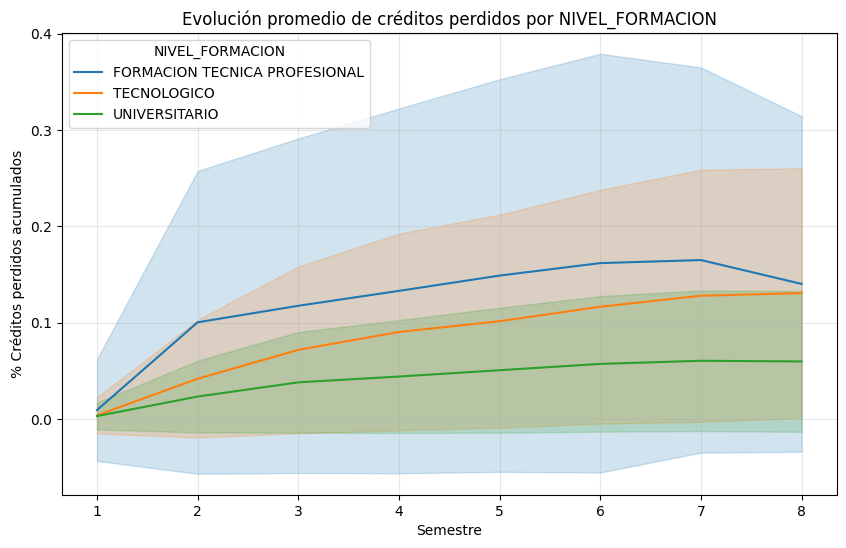

In [9]:
utils.plot_avg_pct_perd_by_group(data,"NIVEL_FORMACION")

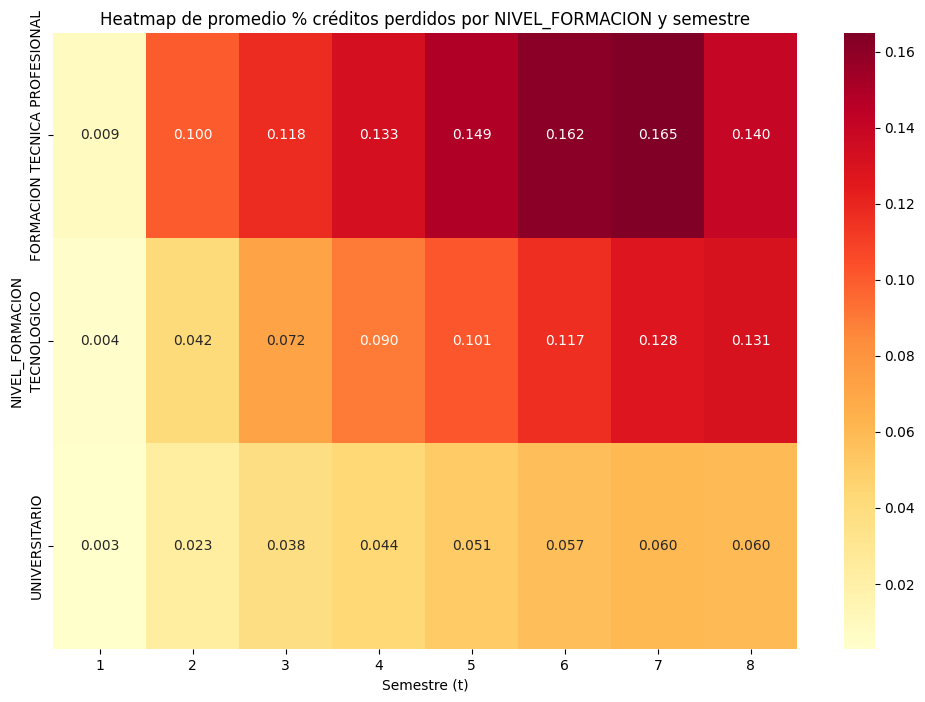

In [10]:
utils.plot_heatmap_cohort(data, "NIVEL_FORMACION")

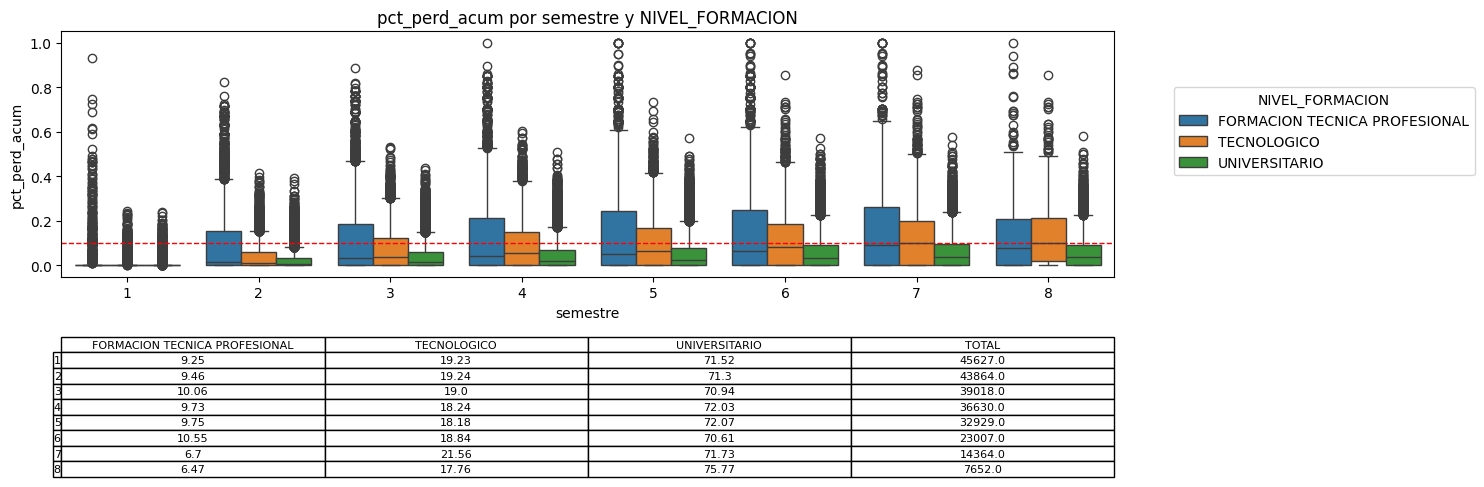

In [11]:
utils_ml.plot_multiple_grouped_boxplots(
    data,
    x_col = "semestre",
    y_col="pct_perd_acum",
    hue_cols = ["NIVEL_FORMACION"],
    hline=0.1,
    table_cols= ["NIVEL_FORMACION"],
    save_path = None
)

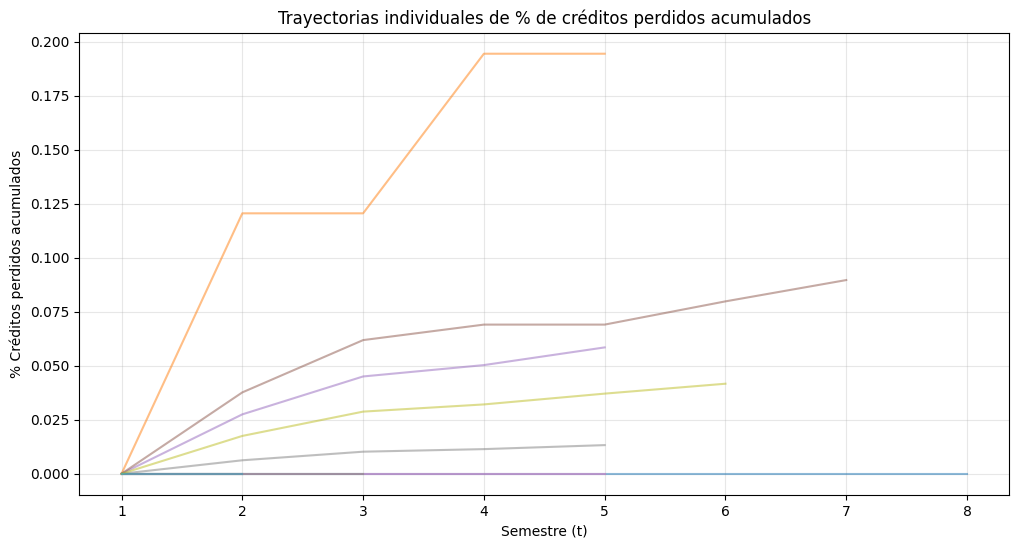

In [12]:
utils.plot_individual_trajectories(
    data,#.query("NIVEL_FORMACION =='UNIVERSITARIO'"),
    sample_size=10,
    random_state=2
)

### **Regresion**

In [13]:
import utils_ml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix

from xgboost import plot_tree
from xgboost import to_graphviz
from xgboost import XGBRegressor

from scipy.stats import uniform, randint

**Acotar la variable pct_perd_acum_clip cuando sus valores no son factibles**
- Un valor de perdida es **no factible** cuando el porcentaje de creditos perdidos por periodo es mayor a los creditos que podía inscribir  

In [14]:
panel_merged_data["pct_perd_acum_clip"] = panel_merged_data.apply(utils.clip_perd_acum,epsilon= 0.01, axis=1)
print(
    f"Numero de personas donde no coincide *pct_perd_acum_clip* con *pct_perd_acum* en la última observacion:\n{panel_merged_data.query("pct_perd_acum_clip != pct_perd_acum and estado_next.isna()", engine="python").shape[0]}"
)

panel_merged_data.to_pickle("pct_perd_acotado.pkl")

Numero de personas donde no coincide *pct_perd_acum_clip* con *pct_perd_acum* en la última observacion:
0


----

# **Clasificacion**

**Observaciones:**
1. Es importante acotar el % de perdida por semestres para que sea consistente
2. ¿Por qué si la bolsa de créditos es mayor a 0.1, el estudiante no tiene un estado de "perdida del beneficio"?

**Definir la variable dependiente** y el **rezago de perdida**

In [15]:
#instanciar la variable sin_bolsa cuando perdida_acumulada >0.1
panel_merged_data["sin_bolsa"] = (panel_merged_data["pct_perd_acum_clip"] >= 0.1).astype(int)
#definir la variable % perdida previa:
panel_merged_data = utils.add_pct_perdida_previa(panel_merged_data)

**Temporal: Puse este filtro porque no entiendo por qué hay estudiantes aun matriculados y sin bolsa de creditos**

In [16]:
#panel_merged_data = panel_merged_data.query(
#    "(pct_perdida_previa<0.1 & pct_perd_acum_clip>=0.1) | (pct_perdida_previa<0.1 & pct_perd_acum_clip<0.1) ")

**Visualizar nuevas distribuciones de % perdida acumulada x semestre**

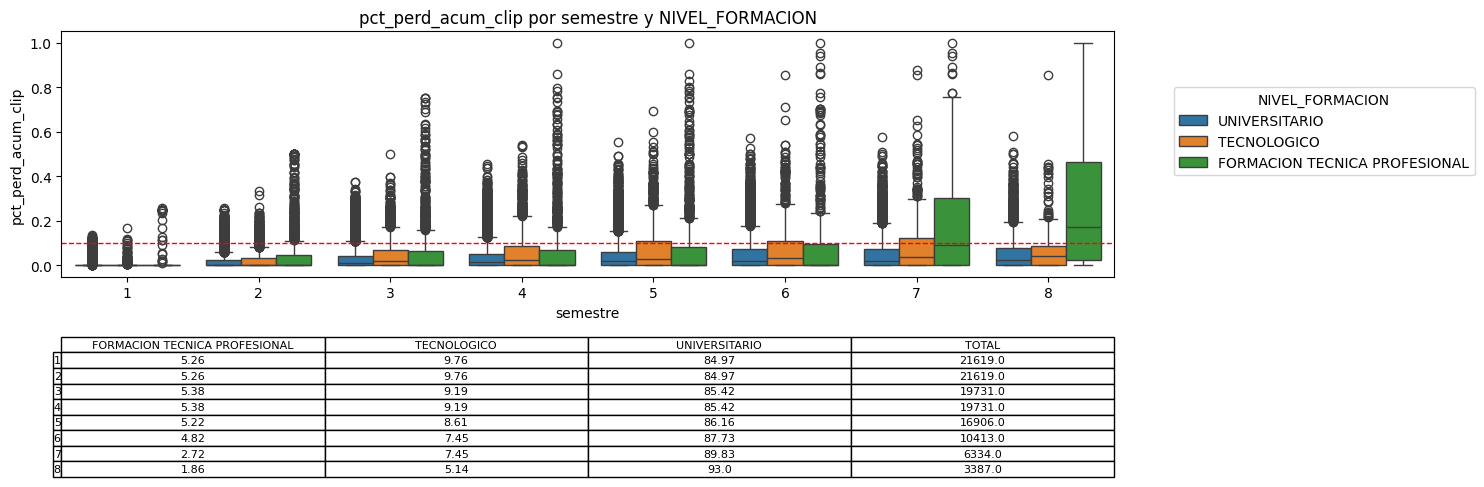

In [17]:
utils_ml.plot_multiple_grouped_boxplots(
    panel_merged_data,
    x_col = "semestre",
    y_col="pct_perd_acum_clip",
    hue_cols = ["NIVEL_FORMACION"],
    hline=0.1,
    table_cols= ["NIVEL_FORMACION"],
    save_path = None
)

**Instanciar los datos**:
- Por ahora solo para universitario

In [18]:
universitario_merged = panel_merged_data.query("NIVEL_FORMACION =='UNIVERSITARIO'").copy()
universitario_merged.columns

Index(['DOCUMENTO', 'NIVEL_SISBEN_4', 'SEXO', 'GRUPO_ETNICO', 'HIJOS',
       'SABER11_PUNTAJE_GLOBAL', 'NIVEL_FORMACION', 'CINE_CAMPO_AMPLIO',
       'MODALIDAD', 'estado', 'periodo_key', 'pct_perd_acum', 'pct_aprob_acum',
       'N_Aplazado', 'N_Matriculado', 'N_Abandono', 'N_Sin_bolsa_de_creditos',
       'N_Pérdida_del_beneficio', 'N_Matriculas_adicionales', 'N_Graduado',
       't', 'estado_next', 'semestre', 'PORCENTAJE_CRED_PERDIDOS', 'ORD_CONV',
       'CREDITOS_PERIODO', 'PERIODOS_BD_SNIES', 'JORNADA', 'TIPO_IES',
       'CREDITOS_PROGRAMA', 'pct_perd_acum_clip', 'sin_bolsa',
       'pct_perdida_previa'],
      dtype='object')

**Visualizar % perdida  para universitario**

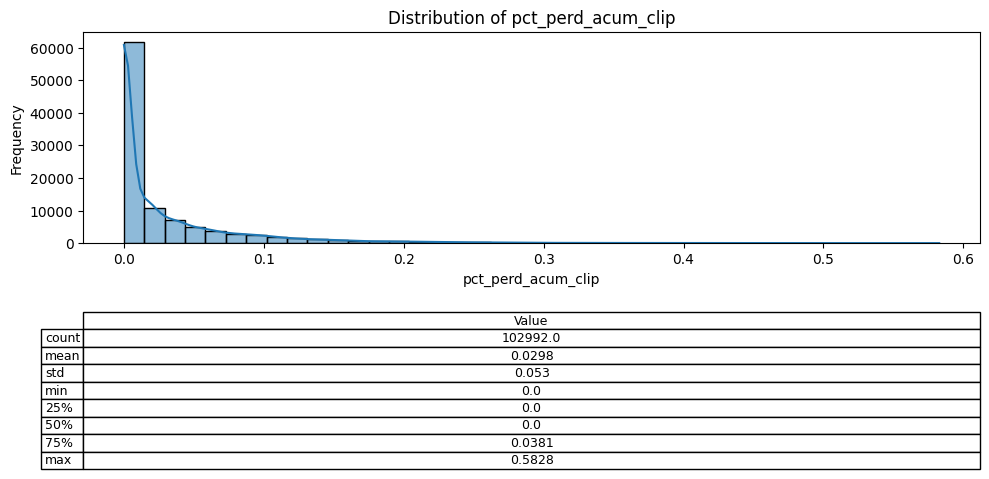

In [19]:
utils_ml.plot_distribution_with_stats(universitario_merged['pct_perd_acum_clip'], bins=40)

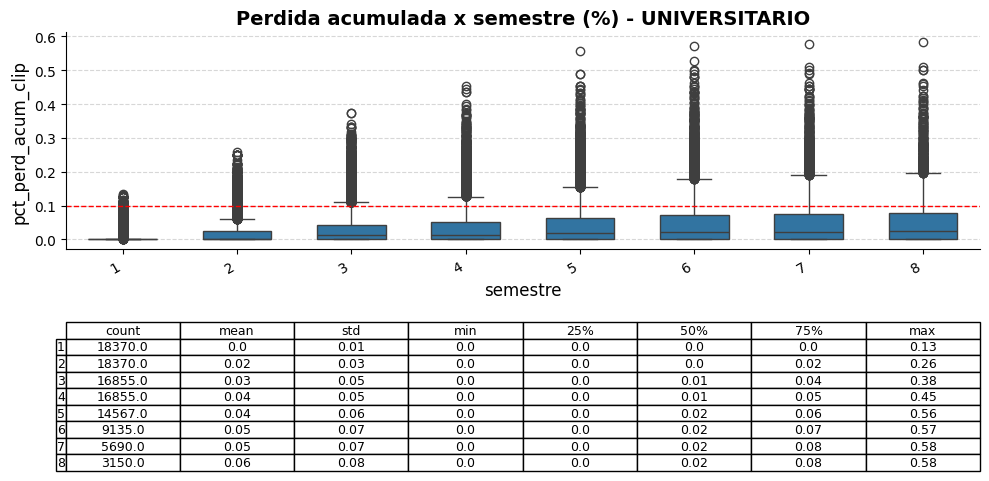

In [20]:
utils_ml.plot_boxplots(
    panel_merged_data.query("NIVEL_FORMACION =='UNIVERSITARIO'"),
    column = "pct_perd_acum_clip",
    by = "semestre",
    title = "Perdida acumulada x semestre (%) - UNIVERSITARIO",
    hline=0.1,
    save_path=None,
    figsize=(10, 5),
    show_table=True,   # <--- nuevo parámetro
)

## **Preprocesamiento**

In [21]:
universitario_merged.columns

Index(['DOCUMENTO', 'NIVEL_SISBEN_4', 'SEXO', 'GRUPO_ETNICO', 'HIJOS',
       'SABER11_PUNTAJE_GLOBAL', 'NIVEL_FORMACION', 'CINE_CAMPO_AMPLIO',
       'MODALIDAD', 'estado', 'periodo_key', 'pct_perd_acum', 'pct_aprob_acum',
       'N_Aplazado', 'N_Matriculado', 'N_Abandono', 'N_Sin_bolsa_de_creditos',
       'N_Pérdida_del_beneficio', 'N_Matriculas_adicionales', 'N_Graduado',
       't', 'estado_next', 'semestre', 'PORCENTAJE_CRED_PERDIDOS', 'ORD_CONV',
       'CREDITOS_PERIODO', 'PERIODOS_BD_SNIES', 'JORNADA', 'TIPO_IES',
       'CREDITOS_PROGRAMA', 'pct_perd_acum_clip', 'sin_bolsa',
       'pct_perdida_previa'],
      dtype='object')

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# --- Features ---
COLUMNAS = [
    "DOCUMENTO",
    "semestre",
    "MODALIDAD",
    "JORNADA",
    "TIPO_IES",
    "CREDITOS_PROGRAMA",
    #"GRUPO_ETNICO",
    #"SEXO",
    #"HIJOS",    
    "pct_perd_acum_clip",
    "sin_bolsa"
    #"pct_perdida_previa"
]

X = universitario_merged[[c for c in COLUMNAS if c not in ["DOCUMENTO", "pct_perd_acum_clip", "sin_bolsa"]]]
y = universitario_merged["sin_bolsa"]

categoricas = ["MODALIDAD", "JORNADA", "TIPO_IES"]#"HIJOS"]#,"GRUPO_ETNICO"]#,"SEXO"]
numericas = [col for col in X.columns if col not in categoricas]

# --- Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop=None), categoricas),
        ("num", "passthrough", numericas)
    ]
)

In [23]:
data.SEXO.unique()

array(['HOMBRE', 'MUJER', 'SIN DATO', nan, 'INTERSEXUAL'], dtype=object)

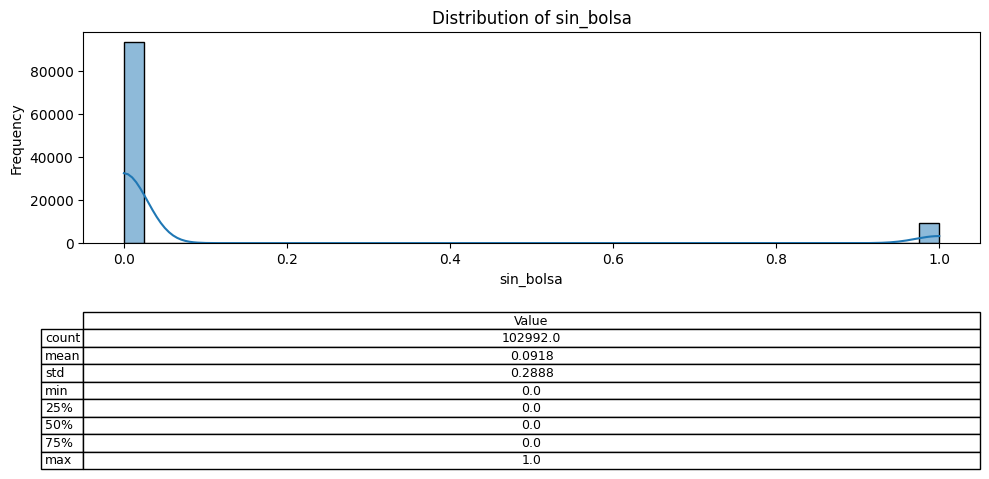

In [24]:
utils_ml.plot_distribution_with_stats(y, bins=40)

**Instanciar modelo**

In [25]:
xgb_model = XGBRegressor(
    objective = "reg:squarederror",
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=7,
    min_child_weight = 25,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
    #reg_lambda = 0.1
)

tree = DecisionTreeRegressor(
    max_depth=8,         # limit depth to avoid overfitting
    min_samples_split=20, # prevent tiny splits
    random_state=42
)

log_reg = LogisticRegression(
    max_iter=1000,       
    solver="lbfgs",      
    class_weight="balanced"  
)


**Instanciar Pipeline**: Esto se puede omitir porque train_pipelines_by_semester lo hace internamente

In [26]:
pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", log_reg)
])

**Split data**

In [27]:
# Crear splits por semestre
splits = utils_ml.make_splits_by_semester(universitario_merged, X, y)

**Instanciar el pipelines**

In [28]:
# --- Función para entrenar pipelines por semestre ---
def train_pipelines_by_semester(splits, preprocessor, base_model):
    pipelines = {}

    for s, data in splits.items():
        pipeline = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("model", base_model)
        ])
        pipeline.fit(data["X_train"], data["y_train"])
        pipelines[s] = pipeline
    
    return pipelines

# --- Entrenar todos los pipelines ---
pipelines = train_pipelines_by_semester(splits, preprocessor, log_reg)

**Resultados y Métricas**

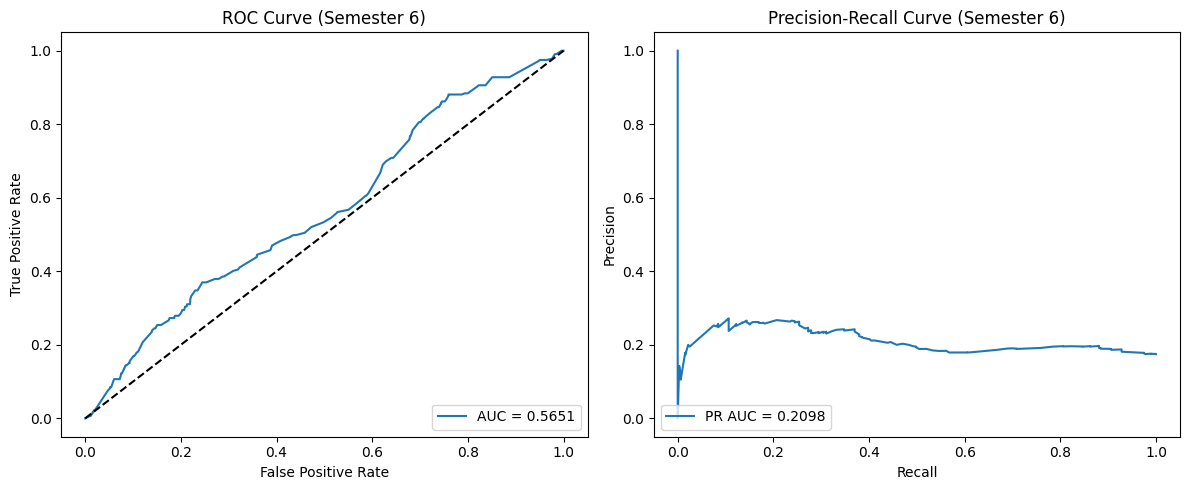

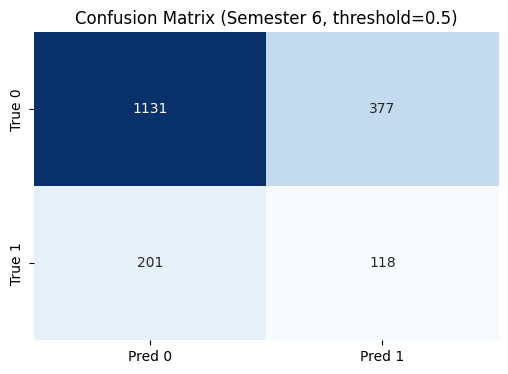


--- Metrics for semester 6 (threshold=0.5) ---
Precision : 0.2384
Recall    : 0.3699
F1        : 0.2899
Roc_auc   : 0.5651
Pr_auc    : 0.2098

Snippet of observed vs predicted:
   y_true   y_proba  y_pred
0       0  0.440674       0
1       1  0.554850       1
2       1  0.430987       0
3       0  0.572292       1
4       1  0.671465       1
5       0  0.556796       1
6       0  0.250794       0
7       0  0.481772       0
8       0  0.456266       0
9       1  0.515345       1


In [29]:
res = utils_ml.evaluate_semester(pipelines, splits, semester=6, threshold=0.5)

**Pronosticar el estado de bolsa de créditos de un dato**

In [37]:
nuevo_dato = pd.DataFrame([{
    "semestre": 3,
    "pct_perdida_previa": 0.0,
    "MODALIDAD": "PRESENCIAL",
    "JORNADA": "DIURNA",
    "TIPO_IES": "PRIVADO",
    "CREDITOS_PROGRAMA": 120
}])

pred = utils_ml.predict_new_student(pipelines, nuevo_dato)
pred

,semestre,pct_perdida_previa,MODALIDAD,JORNADA,TIPO_IES,CREDITOS_PROGRAMA,y_pred,y_proba
0,3,0.0,PRESENCIAL,DIURNA,PRIVADO,120,0,0.457653


----

### **Seccion para regresion**

In [ ]:
results = utils_ml.evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test)

y_pred_train = results["y_pred_train"]
y_pred_test = results["y_pred_test"]


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First plot: observed vs predicted
utils_ml.plot_observed_vs_prediction_scatter(
    y_test, y_pred_test,
    xlabel="pct_perd_acum_clip",
    ax=axes[0]   # send subplot axis
)

# Second plot: error scatter
utils_ml.plot_error_scatter(
    y_test, y_pred_test,
    title="Test Errors vs pct_perd_acum_clip",
    xlabel="pct_perd_acum_clip",
    ax=axes[1]   # send subplot axis
)

plt.tight_layout()
plt.show()